# Prediction of the Surface Patterns of Metal Nanoparticles: Data Processing

This notebook contains the results from data processing in preparation for the machine learning predictions of the surface patterns of metal nanoparticles. The exercise is an attempt to explore the possibility of using a machine learning model to predict the surface patterns to save computational costs. The surface patterns (labels) are generated using from a clustering approach. The details can be found in [this GitHub repository](https://github.com/Jon-Ting/metal-nanoparticle-surface-atom-labelling.git).

## Outline

[Notebook Setups](#setup)

[Data Sets](#datasets)

[Disordered Nanoparticles](#disnps)

<a id='setup'></a>
## Notebook Setups

In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
# Import relevant libraries
from os import chdir, listdir
import pickle
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
# from sklearnex import patch_sklearn
# patch_sklearn()
import sklearn

from natsort import natsorted
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# chdir('/scratch/q27/jt5911')
from trainEvalModels import rmNullLowVarFeats, rmHighCorrFeats

# Print package versions for reproducibility
print('Versions of imported libraries:')
print(f"  matplotlib: {mpl.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  pandas: {pd.__version__}")
print(f"  seaborn: {sns.__version__}")
print(f"  scikit-learn: {sklearn.__version__}")

Versions of imported libraries:
  matplotlib: 3.9.2
  numpy: 1.24.4
  pandas: 1.5.3
  seaborn: 0.12.2
Versions of imported libraries:
  matplotlib: 3.9.2
  numpy: 1.24.4
  pandas: 1.5.3
  seaborn: 0.12.2
  scikit-learn: 1.4.0


Below are some general settings for plotting figures:

In [6]:
# Settings for figures
sns.set_theme(context='paper', style='ticks', palette='colorblind', font='sans-serif', font_scale=1, color_codes=True, rc=None)  # Options are: {paper, notebook, talk, poster}
figSize, DPI, fontSize, labelSize = (3.5, 2.5), None, 'medium', 'small'
legendSize, lineWidth, markerSize = 'x-small', 1, 3
# SMALL_SIZE, MEDIUM_SIZE, LARGE_SIZE, TITLE_SIZE = 8, 10, 12, 14
# plt.rc('font', size=LARGE_SIZE)  # controls default text sizes
# plt.rc('axes', titlesize=TITLE_SIZE)  # fontsize of the axes title
# plt.rc('axes', labelsize=LARGE_SIZE)  # fontsize of the x and y labels
# plt.rc('xtick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('ytick', labelsize=LARGE_SIZE)  # fontsize of the tick labels
# plt.rc('legend', fontsize=LARGE_SIZE)  # legend fontsize
# plt.rc('figure', titlesize=TITLE_SIZE)  # fontsize of the figure title
# PLOT_COLOURS = ['#212121', '#3F51B5', '#303F9F', '#FF5252', '#D32F2F']  # black, blue, deep blue, red, deep red from https://www.materialpalette.com
# mpl.rcParams['axes.prop_cycle'] = mpl.cycler(color=['#303F9F', '#FF5252', '#D32F2F'])

Some handy global variables:

In [7]:
VAR_THRESH = 0.0  # Value other than 0.0 is difficult to decide non-arbitrarily
VERBOSE = True
TRANS_PERC = False
DATA_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/data'
FIG_DIR = '/mnt/c/Users/ASUS/Documents/PhD/Workstation/PaperDrafts/causPath/figs'

Some handy general functions:

In [8]:
def loadData(csvFilePath):
    """
    Load data saved as a csv file.
    """
    df = pd.read_csv(f"{DATA_DIR}/{csvFilePath}", sep=' ', header=None, skiprows=2)
    df.columns = ['x', 'y', 'z', 'xNorm', 'yNorm', 'zNorm', 'ele', 'blavg', 'blmax',
                  'blmin', 'blnum', 'ba1avg', 'ba1max', 'ba1min', 'ba1num', 'ba2avg',
                  'ba2max', 'ba2min', 'ba2num', 'btposavg', 'btnegavg', 'btnegmax',
                  'btnegmin', 'btposmax', 'btposmin', 'btposnum', 'btnegnum', 'cn', 'gcn',
                  'scn', 'sgcn', 'rad', 'q6q6', 'angParam', 'entroParam', 'entroAvgParam',
                  'chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'chi6', 'chi7', 'chi8', 'chi9',
                  'q2', 'q4', 'q6', 'q8', 'q10', 'q12', 'q2avg', 'q4avg', 'q6avg',
                  'q8avg', 'q10avg', 'q12avg', 'disord2', 'disordAvg2', 'disord4',
                  'disordAvg4', 'disord6', 'disordAvg6', 'disord8', 'disordAvg8',
                  'disord10', 'disordAvg10', 'disord12', 'disordAvg12', 'centParam',
                  'Ixx', 'Iyy', 'Izz', 'degenDeg', 'pg', 'csm', 'molRMS', 
                  'allAtomClusters', 'allAuORRSel', 'allPtORRSel', 'allPtCOORSel', 'allCuRWGSRSel', 'allCuCO2RRSel', 'allPtRCORRRSel', 
                  'allAuORRSpc', 'allPtORRSpc', 'allPtCOORSpc', 'allCuRWGSRSpc', 'allCuCO2RRSpc', 'allPtRCORRRSpc', 
                  'allAuORRSen', 'allPtORRSen', 'allPtCOORSen', 'allCuRWGSRSen', 'allCuCO2RRSen', 'allPtRCORRRSen', 
                  'surfAtomClusters', 'surfAuORRSel', 'surfPtORRSel', 'surfPtCOORSel', 'surfCuRWGSRSel', 'surfCuCO2RRSel', 'surfPtRCORRRSel', 
                  'surfAuORRSpc', 'surfPtORRSpc', 'surfPtCOORSpc', 'surfCuRWGSRSpc', 'surfCuCO2RRSpc', 'surfPtRCORRRSpc', 
                  'surfAuORRSen', 'surfPtORRSen', 'surfPtCOORSen', 'surfCuRWGSRSen', 'surfCuCO2RRSen', 'surfPtRCORRRSen']
    labelCols = ['allAtomClusters', 'allAuORRSel', 'allPtORRSel', 'allPtCOORSel', 'allCuRWGSRSel', 'allCuCO2RRSel', 'allPtRCORRRSel', 
                 'allAuORRSpc', 'allPtORRSpc', 'allPtCOORSpc', 'allCuRWGSRSpc', 'allCuCO2RRSpc', 'allPtRCORRRSpc', 
                 'allAuORRSen', 'allPtORRSen', 'allPtCOORSen', 'allCuRWGSRSen', 'allCuCO2RRSen', 'allPtRCORRRSen', 
                 'surfAtomClusters', 'surfAuORRSel', 'surfPtORRSel', 'surfPtCOORSel', 'surfCuRWGSRSel', 'surfCuCO2RRSel', 'surfPtRCORRRSel', 
                 'surfAuORRSpc', 'surfPtORRSpc', 'surfPtCOORSpc', 'surfCuRWGSRSpc', 'surfCuCO2RRSpc', 'surfPtRCORRRSpc', 
                 'surfAuORRSen', 'surfPtORRSen', 'surfPtCOORSen', 'surfCuRWGSRSen', 'surfCuCO2RRSen', 'surfPtRCORRRSen']
    label = df['surfAtomClusters']
    df.drop(['ele', 'pg'] + labelCols, axis=1, inplace=True)
    
    return df, label

<a id='datasets'></a>
## Datasets

The datasets used here are individual simulated metal nanoparticles extracted from collection of nanoparticles generated for studies on the impact of polydispersivity on the properties of metal nanoparticle electrocatalyst ensembles. The collection of nanoparticles are hosted at [CSIRO Data Access Portal](https://data.csiro.au/collection/). The link is [palladium](https://data.csiro.au/collection/csiro:40618).

<a id='ordered'></a>
## Disordered Nanoparticle

Here we process the data for a machine learning model that aims to predict the surface patterns of a disordered palladium nanoparticle to be trained on. We aim to ultimately study the feature importance profile to understand the influential features in the prediction of the surface patterns, and investigate the conditions and/or structural properties that give rise to these patterns.

### Data Loading

In [9]:
# Load features and labels
# ordNPfeats, ordNPlabel = loadData(csvFilePath='PCA_COS1T000_ILS.xyz')
disNPfeats, disNPlabel = loadData(csvFilePath='PCA_disPd1_ILS.xyz')

In [10]:
with open(f"{DATA_DIR}/dfScaledNoLVHCs.pickle", 'rb') as f:
    disNPfeats = pickle.load(f)[0][0][36]

### Data Processing

In [11]:
# Rearrange feature columns based on priorities to be kept (for the highly correlated feature removal step)
# sortedFeats = ['T', 'time', 'tau',
#                'Avg_surf', 'q6q6_avg_surf', 
#                'Perc_S_100', 'Perc_S_111', 'Perc_S_110', 'Perc_S_311', 
#                'Perc_N_surface', 'Perc_N_bulk', 'Volume', 'N_total', 
#                'R_avg', 'R_diff', 'R_std', 'R_min', 'R_max', 'R_skew', 'R_kurt', 
               
#                'Avg_total', 'Avg_bulk', 
#                'Avg_bonds', 'Std_bonds', 'N_bonds', 'Max_bonds', 'Min_bonds', 
#                'angle_avg', 'angle_std', 
#                'q6q6_avg_total', 'q6q6_avg_bulk', 
               
#                'Perc_Curve_1-10', 'Perc_Curve_11-20', 'Perc_Curve_21-30', 'Perc_Curve_31-40', 'Perc_Curve_41-50', 'Perc_Curve_51-60', 'Perc_Curve_61-70', 'Perc_Curve_71-80',
               
#                'Perc_SCN_1', 'Perc_SCN_2', 'Perc_SCN_3', 'Perc_SCN_4', 'Perc_SCN_5', 'Perc_SCN_6', 'Perc_SCN_7', 'Perc_SCN_8', 'Perc_SCN_9', 'Perc_SCN_10', 'Perc_SCN_11', 'Perc_SCN_12', 'Perc_SCN_13', 'Perc_SCN_14', 
#                'Perc_q6q6_S0', 'Perc_q6q6_S1', 'Perc_q6q6_S2', 'Perc_q6q6_S3', 'Perc_q6q6_S4', 'Perc_q6q6_S5', 'Perc_q6q6_S6', 'Perc_q6q6_S7', 'Perc_q6q6_S8', 'Perc_q6q6_S9', 'Perc_q6q6_S10', 'Perc_q6q6_S11', 'Perc_q6q6_S12',
               
#                'Perc_FCC', 'Perc_HCP', 'Perc_ICOS', 'Perc_DECA', 
               
#                'Perc_TCN_1', 'Perc_TCN_2', 'Perc_TCN_3', 'Perc_TCN_4', 'Perc_TCN_5', 'Perc_TCN_6', 'Perc_TCN_7', 'Perc_TCN_8', 'Perc_TCN_9', 'Perc_TCN_10', 'Perc_TCN_11', 'Perc_TCN_12', 'Perc_TCN_13', 'Perc_TCN_14', 'Perc_TCN_15', 'Perc_TCN_16',
#                'Perc_q6q6_T0', 'Perc_q6q6_T1', 'Perc_q6q6_T2', 'Perc_q6q6_T3', 'Perc_q6q6_T4', 'Perc_q6q6_T5', 'Perc_q6q6_T6', 'Perc_q6q6_T7', 'Perc_q6q6_T8', 'Perc_q6q6_T9', 'Perc_q6q6_T10', 'Perc_q6q6_T11', 'Perc_q6q6_T12', 'Perc_q6q6_T13', 'Perc_q6q6_T14', 
#                'Perc_BCN_7', 'Perc_BCN_8', 'Perc_BCN_9', 'Perc_BCN_10', 'Perc_BCN_11', 'Perc_BCN_12', 'Perc_BCN_13', 'Perc_BCN_14', 'Perc_BCN_15', 'Perc_BCN_16',
#                'Perc_q6q6_B0', 'Perc_q6q6_B1', 'Perc_q6q6_B2', 'Perc_q6q6_B3', 'Perc_q6q6_B4', 'Perc_q6q6_B5', 'Perc_q6q6_B6', 'Perc_q6q6_B7', 'Perc_q6q6_B8', 'Perc_q6q6_B9', 'Perc_q6q6_B10', 'Perc_q6q6_B11', 'Perc_q6q6_B12', 'Perc_q6q6_B13', 'Perc_q6q6_B14']
# PdFeatDF = PdFeatDF[sortedFeats]

##### Feature Selection

In [12]:
# Remove features with zero variance and the second feature of each highly correlated feature pairs
CORR_THRESH = 0.90
disNPfeatsNoLowVarDF = rmNullLowVarFeats(featsDF=disNPfeats, rmNull=False, varThresh=VAR_THRESH, verbose=VERBOSE)
disNPfeatsNoLowVarHighCorrDF = rmHighCorrFeats(featsDF=disNPfeatsNoLowVarDF, corrThresh=CORR_THRESH, verbose=VERBOSE)

Removing the features with variance below 0.00...
  Original number of features: 42
  Total number of features left: 42

Removing the second feature from every pair of features with correlation above 0.90...
  Original number of features: 42
    btnegmax btposmin:    0.915
    btnegmin btposmax:    0.948
    gcn entroParam:    0.938
    gcn entroAvgParam:    0.933
    gcn surf:    0.924
  Total number of features left: 37



##### Data Analysis

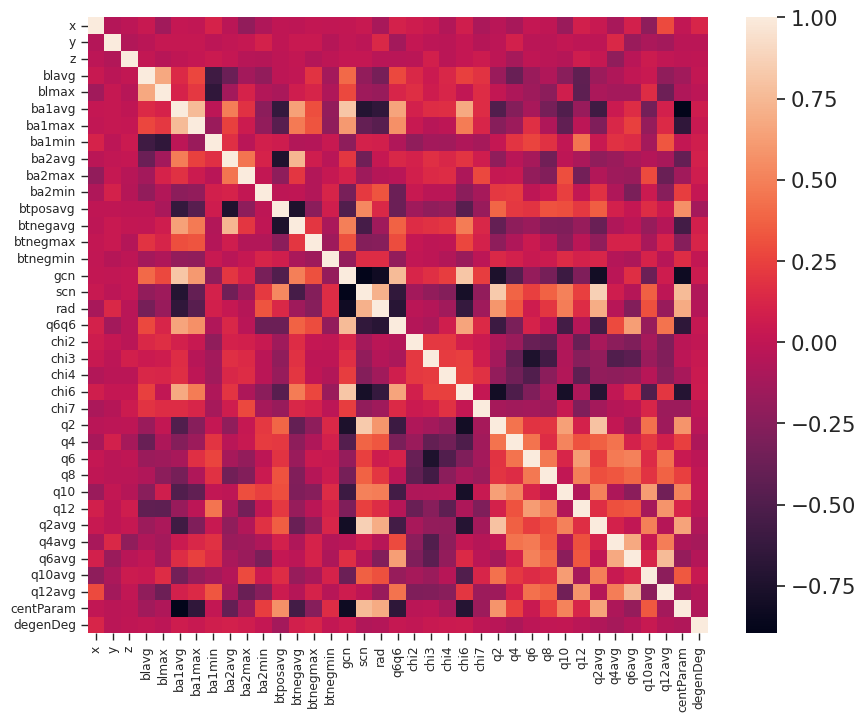

In [13]:
# Correlation heatmap
fig, ax = plt.subplots(figsize=(10, 8), dpi=DPI)
sns.set(font_scale=1.4)
g = sns.heatmap(disNPfeatsNoLowVarHighCorrDF.corr(), ax=ax)
plt.savefig(f"{FIG_DIR}/disNPNoC{int(CORR_THRESH * 100)}CorrHeatmap.png", bbox_inches='tight')

In [14]:
# Merge labels with features
disNPDF = pd.concat([disNPfeatsNoLowVarHighCorrDF, disNPlabel], axis=1)
display(disNPDF)
display(disNPDF.describe())

,x,y,z,blavg,blmax,ba1avg,ba1max,ba1min,ba2avg,ba2max,...,q10,q12,q2avg,q4avg,q6avg,q10avg,q12avg,centParam,degenDeg,surfAtomClusters
0,0.134149,0.568062,0.108340,0.811705,0.903418,0.533333,0.808824,0.411765,0.195402,0.434783,...,0.304910,0.726927,0.538702,0.896801,0.890031,0.221993,0.720657,0.702806,1.0,1
1,0.125030,0.666807,0.101546,0.460560,0.432392,0.475556,0.779412,0.294118,0.264368,0.391304,...,0.517223,0.529411,0.562764,0.934357,0.856140,0.273741,0.613101,0.595995,1.0,1
2,0.168747,0.850367,0.182801,0.857506,0.852897,0.546667,0.823529,0.176471,0.402299,0.608696,...,0.383075,0.359053,0.473216,0.336255,0.502844,0.383031,0.306910,0.556141,1.0,2
3,0.182065,0.344053,0.101272,0.646310,0.986627,0.364444,0.764706,0.411765,0.068966,0.173913,...,0.586889,0.725210,0.664826,0.870474,0.827511,0.270633,0.536808,0.795341,1.0,1
4,0.173866,0.450052,0.114404,0.669211,0.903418,0.764444,0.764706,0.705882,0.252874,0.608696,...,0.548996,0.480743,0.701612,0.759347,0.814828,0.536459,0.459894,0.407191,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
636,0.689105,0.569713,0.807031,0.623410,0.991085,0.946667,0.882353,0.352941,0.689655,0.565217,...,0.364313,0.450707,0.344673,0.119331,0.605139,0.295794,0.355124,0.192930,1.0,0
637,0.789177,0.610201,0.834618,0.557252,0.517088,0.773333,0.926471,0.352941,0.379310,0.434783,...,0.520809,0.732556,0.801901,0.567232,0.780229,0.399016,0.575644,0.431590,1.0,1
638,0.740261,0.543693,0.917833,0.709924,0.794948,0.622222,0.823529,0.470588,0.241379,0.304348,...,0.466162,0.627410,0.768228,0.187112,0.612732,0.259652,0.350976,0.407522,1.0,2
639,0.698424,0.652915,0.877069,0.816794,0.794948,0.706667,0.897059,0.117647,0.206897,0.478261,...,0.467528,0.275030,0.695619,0.381727,0.697741,0.478893,0.421894,0.466818,1.0,1


,x,y,z,blavg,blmax,ba1avg,ba1max,ba1min,ba2avg,ba2max,...,q10,q12,q2avg,q4avg,q6avg,q10avg,q12avg,centParam,degenDeg,surfAtomClusters
count,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,...,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000,641.000000
mean,0.479344,0.524435,0.492962,0.609040,0.709655,0.829815,0.861866,0.405800,0.447469,0.542156,...,0.394938,0.508232,0.426076,0.500168,0.701358,0.336869,0.469444,0.264104,0.995320,0.616225
std,0.239516,0.238269,0.252240,0.142474,0.194867,0.180772,0.141538,0.150375,0.171534,0.175886,...,0.164898,0.182992,0.257351,0.213369,0.137885,0.172321,0.177496,0.185730,0.068305,0.778210
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.286977,0.331466,0.300761,0.534351,0.561664,0.728889,0.838235,0.294118,0.333333,0.434783,...,0.275099,0.379398,0.192879,0.341716,0.636455,0.205674,0.335231,0.111488,1.000000,0.000000
50%,0.471242,0.528841,0.498518,0.618321,0.732541,0.924444,0.911765,0.411765,0.425287,0.521739,...,0.375426,0.505592,0.364734,0.487804,0.714572,0.309334,0.470641,0.235754,1.000000,0.000000
75%,0.668467,0.719001,0.697779,0.702290,0.866270,0.955556,0.941176,0.470588,0.551724,0.652174,...,0.489832,0.646652,0.673117,0.665285,0.797356,0.441683,0.584233,0.384614,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000


In [18]:
# Correlation of Each Feature with Surface Patterns
# for col in disNPDF.columns:
#     g = sns.regplot(data=disNPDF, x=col, y='surfAtomClusters')
#     g.figure.set_size_inches(4, 3)
#     plt.show()

##### Data Storage

In [17]:
with open(f"{DATA_DIR}/processeddisNPdataNoC{int(CORR_THRESH * 100)}.pickle", 'wb') as f:
    pickle.dump(disNPDF, f)